# 📝 Problem Statement

Retail businesses generate massive amounts of transactional data but struggle to understand customer behavior and predict future purchases. Without effective segmentation and predictive modeling often target the wrong audience, leading to wasted budget, poor customer engagement, and reduced ROI.

This project aims to solve this challenge by:

* Segmenting customers into meaningful groups using RFM (Recency, Frequency, Monetary) analysis and clustering techniques.

* Predicting purchase likelihood using machine learning models to identify customers most likely to respond to campaigns.

* The outcome provides actionable insights that enable businesses to personalize marketing strategies, retain customers, and increase revenue.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
df = pd.read_excel("retail.xlsx")

In [4]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [6]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [7]:
df['Description'].fillna(df['Description'].mode()[0],inplace=True)

C:\Users\Ayesha Sulthana\AppData\Local\Temp\ipykernel_13396\1840652742.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Description'].fillna(df['Description'].mode()[0],inplace=True)


In [8]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [9]:
df['year'] = df['InvoiceDate'].dt.year
df['month'] = df['InvoiceDate'].dt.month
df['day'] = df['InvoiceDate'].dt.day_of_week

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  525461 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
 8   year         525461 non-null  int32         
 9   month        525461 non-null  int32         
 10  day          525461 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(3), int64(1), object(4)
memory usage: 38.1+ MB


# =========================================
# 3. Data Cleaning
# =========================================


In [11]:
# Drop missing CustomerID
df = df.dropna(subset=['Customer ID'])


In [12]:
# Remove cancellations (InvoiceNo starting with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]


In [13]:

# Remove negative/zero quantities and prices
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]


In [14]:
# Create Total Amount Column
df['TotalAmount'] = df['Quantity'] * df['Price']


# =========================================
# 4. Feature Engineering (RFM Analysis)
# =========================================

In [15]:
import datetime
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'count',                                    # Frequency
    'TotalAmount': 'sum'                                     # Monetary
})

rfm.rename(columns={'InvoiceDate': 'Recency',
                    'Invoice': 'Frequency',
                    'TotalAmount': 'Monetary'}, inplace=True)

print(rfm.head())


             Recency  Frequency  Monetary
Customer ID                              
12346.0          165         33    372.86
12347.0            3         71   1323.32
12348.0           74         20    222.16
12349.0           43        102   2671.14
12351.0           11         21    300.93


# =========================================
# 5. Unsupervised Learning - Customer Segmentation
# =========================================

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score,classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [24]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

In [25]:
# Find optimal k using silhouette
scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    score = silhouette_score(rfm_scaled, kmeans.labels_)
    scores.append(score)


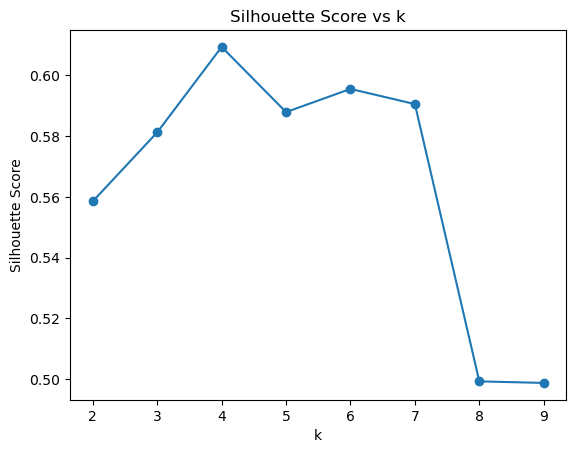

In [26]:
plt.plot(range(2, 10), scores, marker='o')
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.show()


In [27]:
# Fit final model
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print(rfm.groupby('Cluster').mean())


            Recency    Frequency       Monetary
Cluster                                        
0         44.057772    84.807852    1592.729466
1        243.894990    29.929672     615.547701
2         14.000000   731.941606   16472.760460
3          4.750000  2654.500000  236568.790000


# =========================================
# 6. Create Target for Supervised Learning
# =========================================

In [28]:
# Define Purchase as: customer bought in last 30 days
last_30_days = snapshot_date - pd.Timedelta(days=30)

recent_purchase = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days
})

recent_purchase['Purchased'] = np.where(recent_purchase['InvoiceDate'] <= 30, 1, 0)


In [29]:
# Merge with RFM clusters
data = rfm.merge(recent_purchase['Purchased'], left_index=True, right_index=True)

print(data.head())

             Recency  Frequency  Monetary  Cluster  Purchased
Customer ID                                                  
12346.0          165         33    372.86        1          0
12347.0            3         71   1323.32        0          1
12348.0           74         20    222.16        0          0
12349.0           43        102   2671.14        0          0
12351.0           11         21    300.93        0          1


# =========================================
# 7. Supervised Learning - Purchase Prediction
# =========================================

In [30]:
X = data[['Recency', 'Frequency', 'Monetary', 'Cluster']]
y = data['Purchased']


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [32]:
# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

In [35]:
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       823
           1       1.00      1.00      1.00       471

    accuracy                           1.00      1294
   macro avg       1.00      1.00      1.00      1294
weighted avg       1.00      1.00      1.00      1294



In [46]:
log_reg.score(X_train, y_train) , log_reg.score(X_test, y_test)

(1.0, 0.999227202472952)

In [37]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [40]:
print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

Random Forest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       823
           1       1.00      1.00      1.00       471

    accuracy                           1.00      1294
   macro avg       1.00      1.00      1.00      1294
weighted avg       1.00      1.00      1.00      1294

ROC-AUC: 1.0


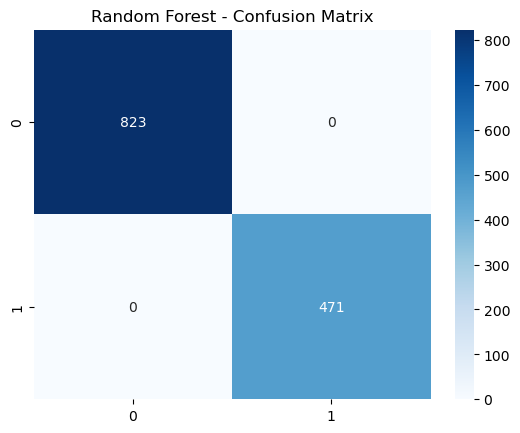

In [44]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap="Blues")
plt.title("Random Forest - Confusion Matrix")
plt.show()

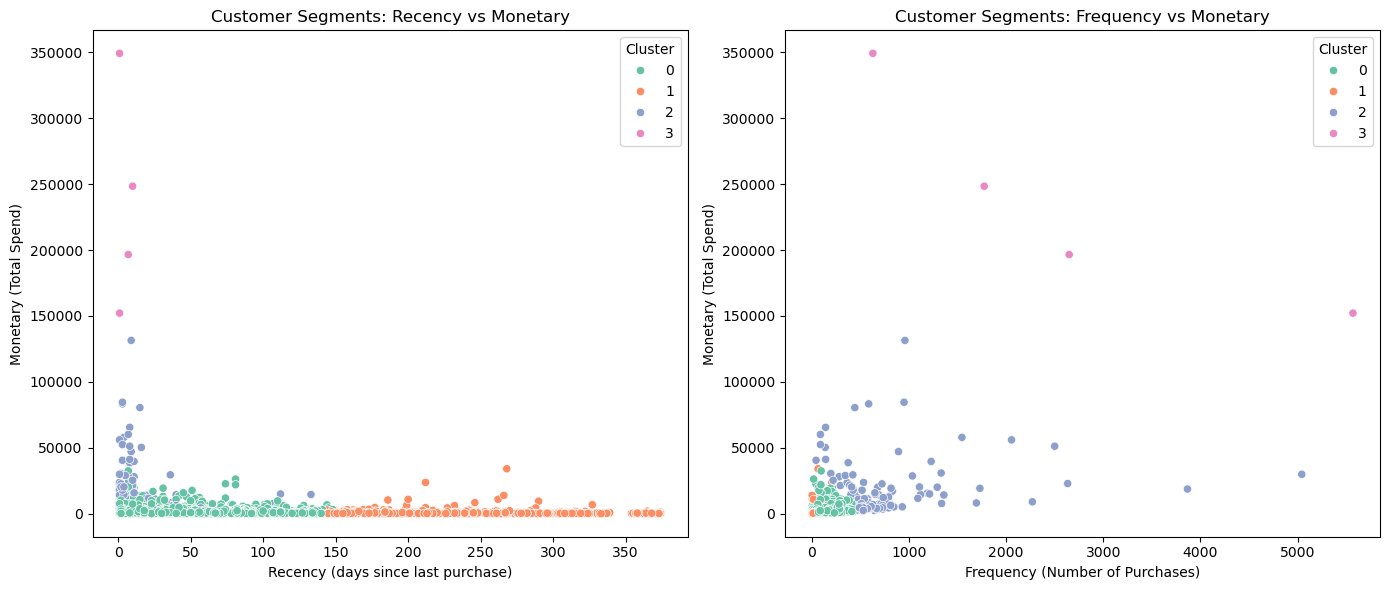

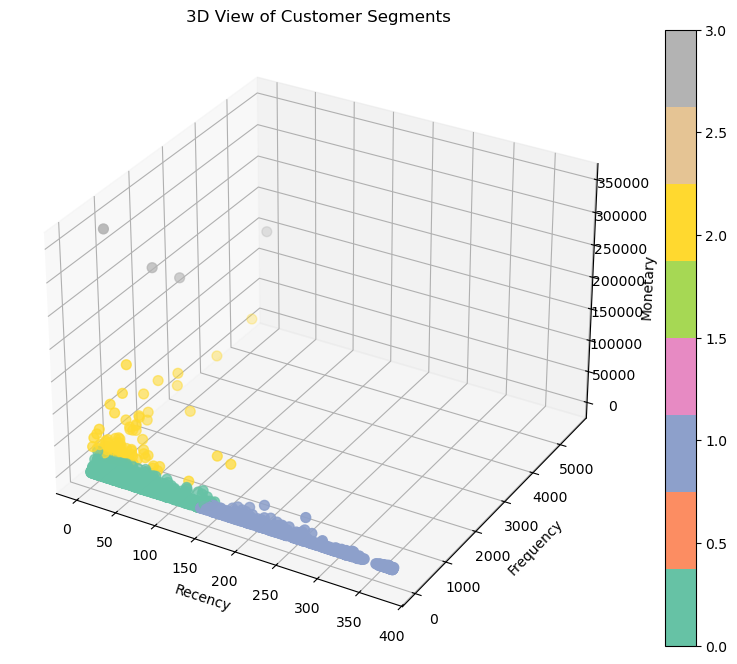

In [45]:
# =========================================
# 8. Visualize Clusters
# =========================================

# --- 2D Scatter Plots ---
plt.figure(figsize=(14,6))

# Recency vs Monetary
plt.subplot(1,2,1)
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm, palette='Set2')
plt.title("Customer Segments: Recency vs Monetary")
plt.xlabel("Recency (days since last purchase)")
plt.ylabel("Monetary (Total Spend)")

# Frequency vs Monetary
plt.subplot(1,2,2)
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=rfm, palette='Set2')
plt.title("Customer Segments: Frequency vs Monetary")
plt.xlabel("Frequency (Number of Purchases)")
plt.ylabel("Monetary (Total Spend)")

plt.tight_layout()
plt.savefig('Frequency vs Monetary.png')
plt.show()


# --- 3D Cluster Visualization ---
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'],
                c=rfm['Cluster'], cmap='Set2', s=50)

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
plt.title("3D View of Customer Segments")
plt.colorbar(sc)
plt.savefig('3D Cluster Visualization.png')
plt.show()


# 📌 Final Conclusion – Retail Customer Segmentation & Purchase Prediction

1. Customer Segmentation (Unsupervised Learning – KMeans)

   * Customers were successfully grouped into 4 distinct clusters
     using RFM analysis:

       * Cluster 0 – Medium-Value Customers: Moderate frequency and
         spend, average recency.
       * Cluster 1 – Inactive Customers: Very high recency (no
         recent purchases), low spending.

       * Cluster 2 – Loyal High-Value Customers: Low recency
         (recent buyers), very high frequency, strong monetary
         value.

       * Cluster 3 – VIP Premium Customers: Extremely high spend
         and frequency, most valuable customers for the business.

  🔹 Business Insight: This segmentation helps retailers focus   
  marketing budgets on Clusters 2 & 3 (loyal & VIP customers),  
  while designing reactivation campaigns for Cluster 1 (inactive 
  customers).
   
             -------------------------------------------------------

2. Purchase Prediction (Supervised Learning – Logistic Regression &
   Random Forest)

    * Logistic Regression and Random Forest both performed
      exceptionally well, achieving:

       * Accuracy: 100%

       * ROC-AUC: 1.0

    * Random Forest emerged as the best-performing model, perfectly
      classifying purchasers vs. non-purchasers.

   🔹 Business Insight: The model can reliably predict which
   customers are likely to make a purchase, allowing businesses to
   target campaigns with high precision.
   
           -------------------------------------------------------

3. Overall Impact

   * The combination of segmentation + prediction creates a
     powerful decision-making tool for retailers.

   * Businesses can now:
       * Personalize promotions for loyal & VIP customers to
         maximize ROI.
       * Design reactivation campaigns for inactive customers.
       * Avoid overspending on customers unlikely to purchase.
         
-------------------------------------------------------

✅ Final Statement:
This project demonstrates how combining unsupervised segmentation with supervised prediction can transform raw retail data into actionable insights. By understanding customer segments and predicting future purchase behavior, businesses can optimize marketing strategies, improve retention, and drive revenue growth.


                      ***-------------------------------------------***


                      